In [1]:
import h2o
from IPython import get_ipython
import jupyter
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import seaborn as sns
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator

h2o.init(max_mem_size = '12G', ip = '127.0.0.1', port = "54321")

Checking whether there is an H2O instance running at http://127.0.0.1:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "13.0.2" 2020-01-14; Java(TM) SE Runtime Environment (build 13.0.2+8); Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from /Users/wbchoi/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/q1/z7qbw9z12vq12k5vd65yw2tw0000gn/T/tmpmm2baw26
  JVM stdout: /var/folders/q1/z7qbw9z12vq12k5vd65yw2tw0000gn/T/tmpmm2baw26/h2o_wbchoi_started_from_python.out
  JVM stderr: /var/folders/q1/z7qbw9z12vq12k5vd65yw2tw0000gn/T/tmpmm2baw26/h2o_wbchoi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.5
H2O_cluster_version_age:,2 months and 25 days
H2O_cluster_name:,H2O_from_python_wbchoi_giawis
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [2]:
h2o_data = h2o.import_file('/Users/wbchoi/PycharmProjects/ai_projects/C_ITS/prediction_modeling/full_data_kma_hours_lightgbm_feature_extract.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
h2o_data.shape

(15797629, 37)

In [4]:
h2o_data['SAGO_YN'].table()

SAGO_YN,Count
0,1.57939e+07
1,3751


In [5]:
# h2o_data[-1] = h2o_data[-1].asfactor()
predictors = h2o_data.columns[0:37]
response = 'SAGO_YN'

# train : test = 0.8 : 0.2
train, test = h2o_data.split_frame(ratios = [0.8], seed = 7)

In [6]:
# train_df = train.as_data_frame()
# test_df = test.as_data_frame()

In [7]:
train_df = train[train['SAGO_YN'] == 0]
train_df = train.drop(['SAGO_YN'], axis = 1)

Y_test_df = test['SAGO_YN']
test_df = test.drop(['SAGO_YN'], axis = 1)

In [8]:
Y_test_df = Y_test_df.as_data_frame()

In [9]:
Y_test_df.shape

(3159469, 1)

In [10]:
train_df.shape

(12638160, 36)

In [11]:
# train_h2o = h2o.H2OFrame(train_df) # converting to h2o frame
# test_h2o = h2o.H2OFrame(test_df)
# x = train_h2o.columns
x = train_df.columns

In [12]:
anomaly_model = H2ODeepLearningEstimator(activation = "tanh",
                                hidden = [18,9,9,18],
                                epochs = 100,
                                standardize = True,
                                stopping_metric = 'MSE', # MSE for autoencoders
                                loss = 'automatic',
                                train_samples_per_iteration = 1024,
                                shuffle_training_data = True,     
                                autoencoder = True,
                                l1 = 10e-5)

In [13]:
anomaly_model.train(x = x, training_frame = train_df)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [14]:
anomaly_model._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,SUB_YN,1.000000,1.000000,0.093392
1,BUS_YN,0.991646,0.991646,0.092612
2,WD,0.929659,0.929659,0.086822
3,A3_ROADTYPE_1_YN,0.889789,0.889789,0.083099
4,A1_BARR_03_YN,0.765515,0.765515,0.071493
5,A1_LANE_04_YN,0.726457,0.726457,0.067845
6,CW_YN,0.677948,0.677948,0.063315
7,REST_VEH,0.596857,0.596857,0.055742
8,A1_BARR_02_YN,0.456366,0.456366,0.042621
9,ROAD_TYPE,0.427241,0.427241,0.039901


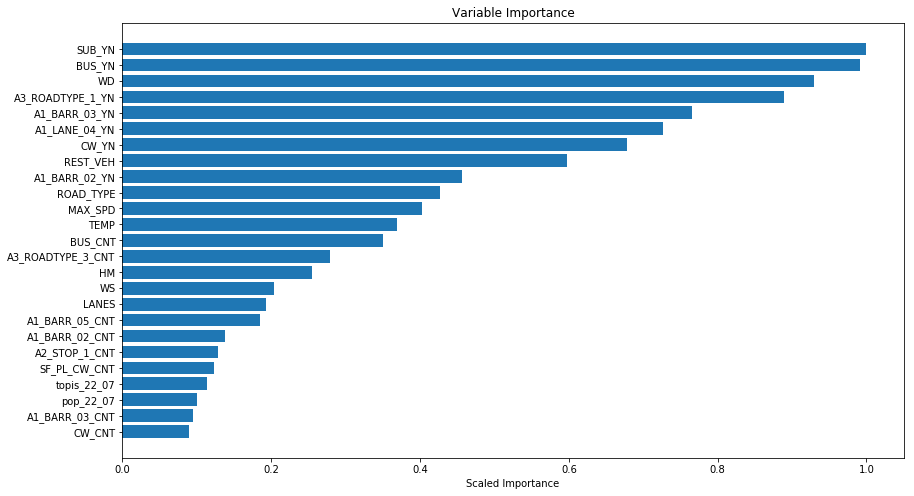

In [15]:
# plotting the variable importance
rcParams['figure.figsize'] = 14, 8
#plt.rcdefaults()
fig, ax = plt.subplots()

variables = anomaly_model._model_json['output']['variable_importances']['variable']
var = variables[0:25]
y_pos = np.arange(len(var))

scaled_importance = anomaly_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:25]

ax.barh(y_pos, sc, align='center', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

Text(0.5, 0, 'epoch')

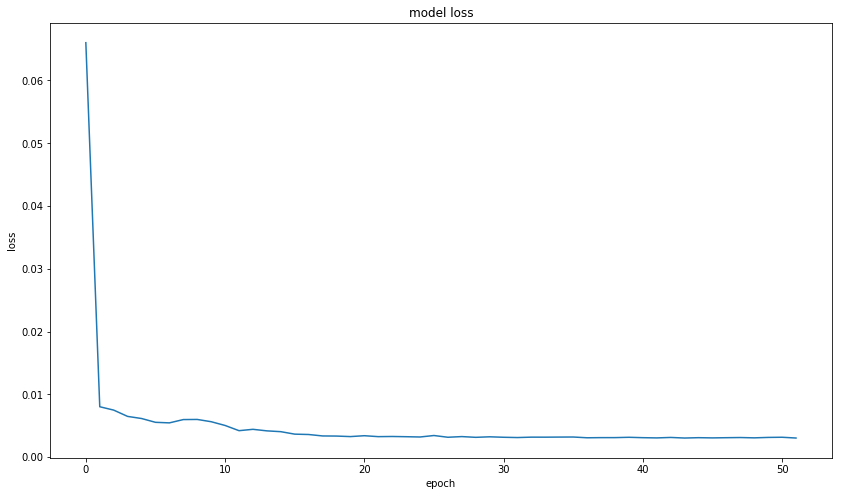

In [16]:
# plotting the loss
scoring_history = anomaly_model.score_history()
rcParams['figure.figsize'] = 14, 8
plt.plot(scoring_history['training_mse'])
#plt.plot(scoring_history['validation_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

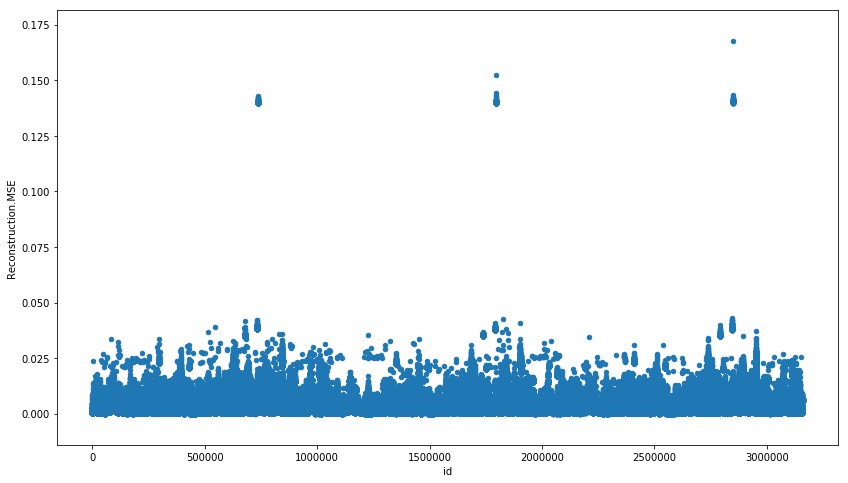

In [17]:
test_rec_error = anomaly_model.anomaly(test_df) 
# anomaly is a H2O function which calculates the error for the dataset
test_rec_error_df = test_rec_error.as_data_frame() # converting to pandas dataframe

# plotting the testing dataset against the error
test_rec_error_df['id']=test_rec_error_df.index

rcParams['figure.figsize'] = 14, 8
test_rec_error_df.plot(kind="scatter", x='id', y="Reconstruction.MSE")

plt.show()

In [18]:
# predicting the class for the testing dataset
predictions = anomaly_model.predict(test_df)

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [19]:
# test_rec_error_df['Reconstruction.MSE'].shape
test_rec_error_df.astype

<bound method NDFrame.astype of          Reconstruction.MSE       id
0                  0.000915        0
1                  0.000759        1
2                  0.000533        2
3                  0.000511        3
4                  0.000635        4
...                     ...      ...
3159464            0.006313  3159464
3159465            0.006288  3159465
3159466            0.006425  3159466
3159467            0.006008  3159467
3159468            0.006007  3159468

[3159469 rows x 2 columns]>

In [20]:
error_df = pd.DataFrame({'reconstruction_error': test_rec_error_df['Reconstruction.MSE'],
                        'true_class': Y_test_df['SAGO_YN']})
error_df.describe()

,reconstruction_error,true_class
count,3.159469e+06,3.159469e+06
mean,3.124181e-03,2.348496e-04
std,5.326549e-03,1.532301e-02
min,4.550453e-05,0.000000e+00
25%,9.392872e-04,0.000000e+00
50%,1.784114e-03,0.000000e+00
75%,3.681717e-03,0.000000e+00
max,1.675942e-01,1.000000e+00


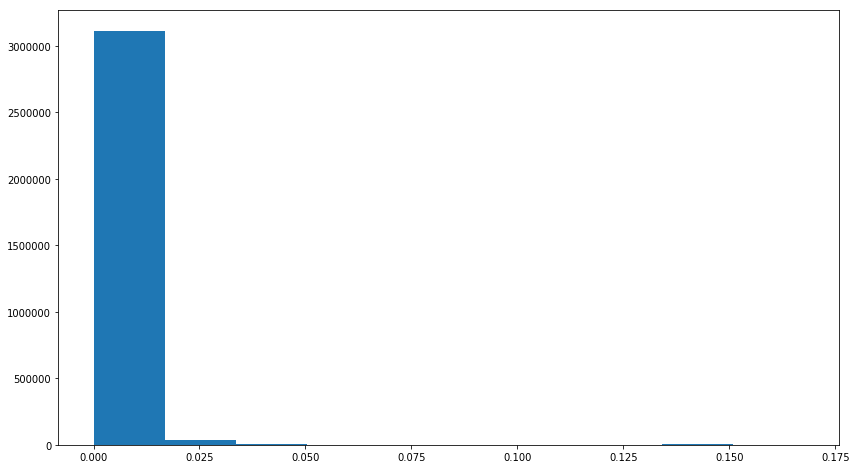

In [21]:
# reconstruction error for the normal transactions in the testing dataset
fig = plt.figure()
ax = fig.add_subplot(111)
rcParams['figure.figsize'] = 14, 8
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

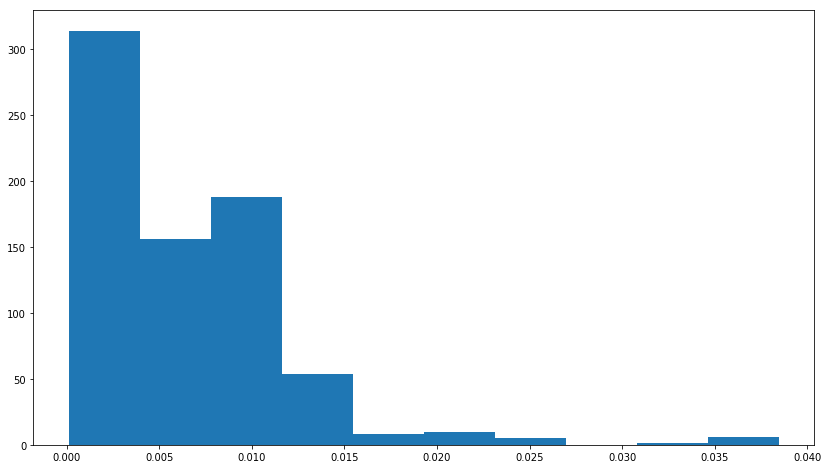

In [22]:
# reconstruction error for the fraud transactions in the testing dataset
fig = plt.figure()
ax = fig.add_subplot(111)
rcParams['figure.figsize'] = 14, 8
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

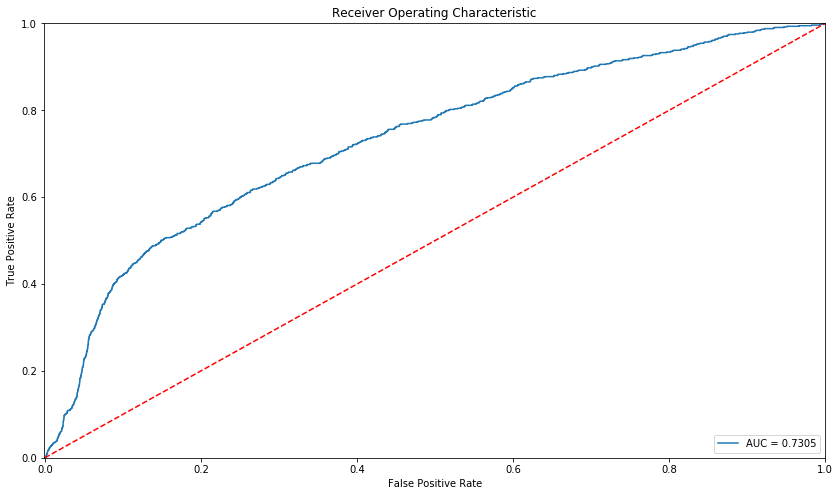

In [24]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

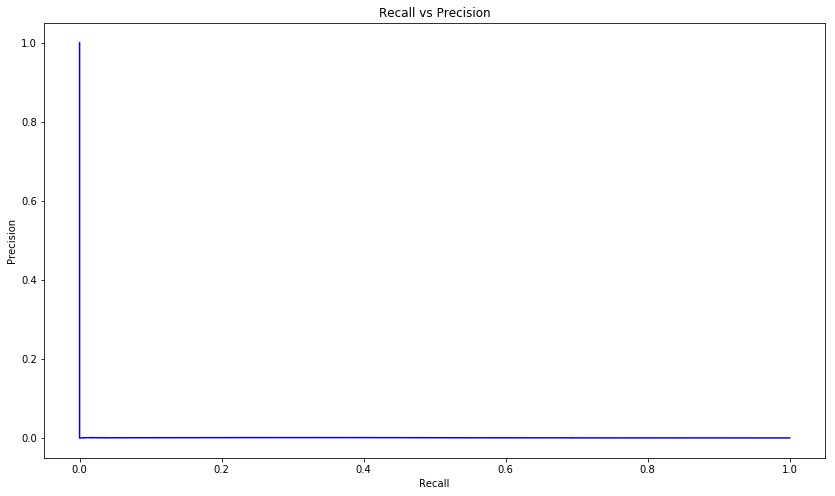

In [25]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

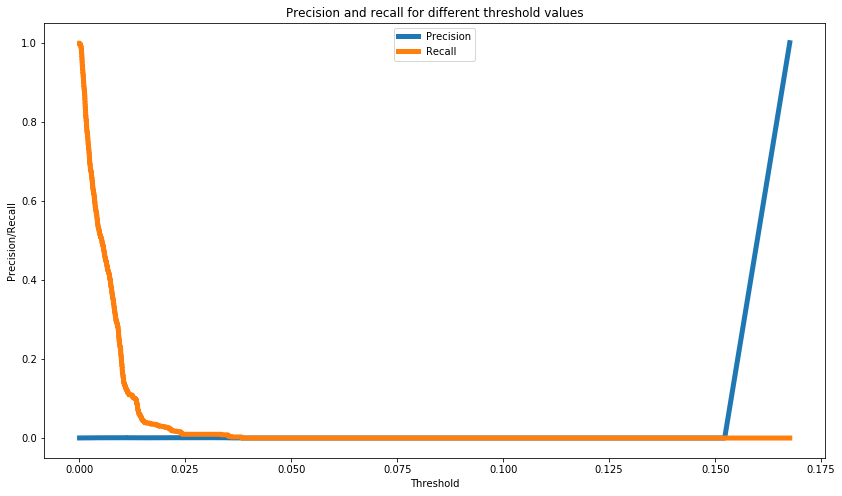

In [26]:
plt.plot(th, precision[1:], label="Precision",linewidth=5)
plt.plot(th, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

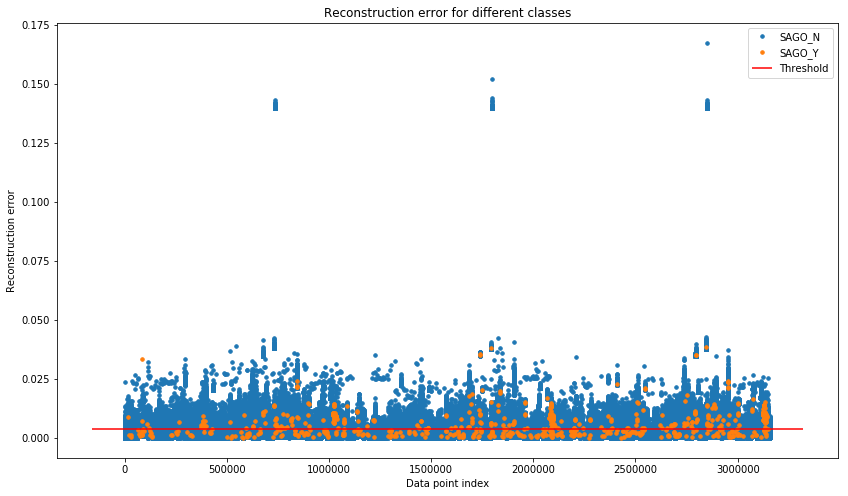

In [35]:
# plot the testing set with the threshold

# threshold 이상: 교통사고 Y, threshold 미만: 교통사고 N
threshold = 0.004

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "SAGO_Y" if name == 1 else "SAGO_N")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

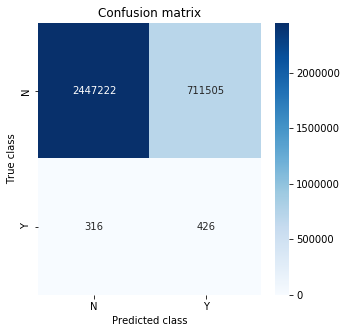

In [36]:
LABELS = ['N', 'Y']
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap = 'Blues');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [37]:
csr = classification_report(error_df.true_class, y_pred)
print(csr)

              precision    recall  f1-score   support

           0       1.00      0.77      0.87   3158727
           1       0.00      0.57      0.00       742

    accuracy                           0.77   3159469
   macro avg       0.50      0.67      0.44   3159469
weighted avg       1.00      0.77      0.87   3159469



In [38]:
tp = conf_matrix[1,1]
tn = conf_matrix[0,0]
fp = conf_matrix[0,1]
fn = conf_matrix[1,0]

acc = (tp + tn) / (tp + tn + fp + fn)
prec = tp / (tp+fp)
rec = tp / (tp+fn)
spec = tn / (fp + tn)

print('정확도 (Accuracy): %f , 정밀도 (Precision): %f , 재현율 (Recall): %f , 특이도 (Specificity): %f' % (acc, prec, rec, spec))

정확도 (Accuracy): 0.774702 , 정밀도 (Precision): 0.000598 , 재현율 (Recall): 0.574124 , 특이도 (Specificity): 0.774749
